# Predict REM sleep transitions

(1) Using Linear Discriminant Analysis (LDA) determine how long before a transition, we can predict (above chance level) whether the mouse will transition to REM sleep or wake/MA

(2) Test whether we can predict how long it will take till the mouse transitions to REM sleep the next time

(3) Just looking a single infraslow (IS) cycle: How well can we predict whether the mouse goes to REM or not ... net yet implemented


Alternative approach (to do):
Cut out activity of firing rates (for each unit) for each time bin; build matrix; then perform PCA followed by LDA

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/tortugar/My Drive/Penn/Programming/PySleep')
import sleepy
sys.path.append('/Users/tortugar/My Drive/Penn/Programming/Neuropixels')
sys.path.append('/Users/tortugar/My Drive/Penn/Programming/Pyspike')
sys.path.append('/Users/tortugar/My Drive/Penn/Programming/Photometry')
import neuropyx as nx
import spyke
import pyphi

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import re
import scipy
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')
# turn warnings on again:
#warnings.filterwarnings('default')

# for interactive plots:
%matplotlib ipympl

plt.close('all')

/Users/tortugar/opt/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/tortugar/opt/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## (1) LDA

(a) Perform PCA on the firing rates.

(b) Align for each mouse the PCs to have the right orientation

(c) Go to each NREM$\rightarrow$REM or NREM$\rightarrow$Wake transition, cut out the preceding PCs; potentially downsample PCs in time (parameter `ndown`)

(d) For each preceding time bin predict using LCA whether the mouse will go to REM or wake.

Todo
Restrict the analysis to specific subregions: Which areas are most predictive?
Further distinguish between MAs and wake

In [2]:
mice = ['DL159', 'DL194', 'DL172', 'DL161', 'DL108', 'DL158']
#mice = ['DL159', 'DL194', 'DL172', 'DL158']
pc_signs = {'DL159': [1, -1], 'DL161': [1, -1], 'DL172':[-1,-1], 
            'DL108':[1,-1], 'DL194':[1,1], 'DL177_20':[1,-1], 'DL158':[1,1]}

br_regions = ['CS', 'RPO',  'DR', 'PAG', 'P', 'RPO', 'CLI', 'MB']
br_regions = ['P', 'CS', 'RPO', 'MB', 'DR', 'PAG', 'MRN', 'PRNc', 'PRNr']
#br_regions = ['PAG', 'DR', 'MRN', 'CLI', 'MB']
##br_regions = ['PAG', 'DR']

#br_regions = ['PRNc', 'PRNr', 'RPO', 'P', 'LDT']
#br_regions = ['P', 'PRNc', 'PRNr']

#br_regions = ['CS', 'RPO',  'DR', 'PAG', 'P', 'RPO', 'CLI', 'MB'] + ['PAG', 'DR', 'MRN', 'CLI', 'MB']
#br_regions = ['P']

restrict_regions = True

pplot = False
nsmooth = 1.5
#win = 300
dt = 2.5
ndown = 2
ma_thr = 10
ndim = 4
pplot_pcs = False

# number of time steps to go back in history:
win = 200

nback = int(win / (dt * ndown))




#win = int(nback * dt * ndown)

iwin = nback * ndown

rem_data, wake_data = [], []
rem_dict = {i:[] for i in range(nback)}
wake_dict = {i:[] for i in range(nback)}
# For each mouse perform PCA; 
# then determine form each mouse all NREM to Wake and all NREM to REM transitions
# for each transition cut out the preceding PCs; downsample them by factor $ndown
# then construct for both NREM to Wake and NREM to REM $nback matrices, for each  
# of the $nback preceding time bins
# Importantly, for a single transition from a single mouse we have $ndim data points;
# in other words the number of units of a given mouse does not play any role.
for mouse in mice:
    config_file = os.path.join('/Users/tortugar/My Drive/Penn/Programming/Neuropixels', 'mouse_config.txt')
    units, cell_info, M, kcut = nx.load_mouse(mouse, config_file)    
    nx.exclude_units(units, mouse, config_file)
    
    if restrict_regions:
        ids = cell_info[cell_info.brain_region.isin(br_regions)]['ID']
        ids = [id for id in ids if re.match('.*_good$', id)]
        ids = [id for id in ids if id in list(units.columns)]
        units = units[ids]
        
    PC, V, Vh, idx = nx.sleep_components(units, M, ndim=ndim, nsmooth=nsmooth, wake_dur=60, 
                                         pc_sign=pc_signs[mouse], pzscore=True, 
                                         wake_break=20, kcuts=kcut, detrend=True, ylim=[], pplot=pplot_pcs)
    
    if restrict_regions:
        pc_sign_corr = nx.align_pcsign(PC, mouse, kcuts=kcut, config_file=config_file)
        pprint(pc_sign_corr)
        
        for i,s in enumerate(pc_sign_corr):
            PC[i,:] = PC[i,:] * s
    
    # remaining indices after cutting out KCUT intervals
    tidx = nx.kcut_idx(M, PC, kcuts=kcut)
    M = M[tidx]
    
    # flatten out MAs
    seq = sleepy.get_sequences(np.where(M==2)[0])
    for s in seq:
        if len(s)*dt < ma_thr:
            M[s] = 3

    # get all starts of wake sequnces
    wake_idx = []
    seq = sleepy.get_sequences(np.where(M==2)[0])
    for s in seq:
        istart = s[0]
        if istart >= iwin:
            wake_idx.append(istart)

    # get all starts of REM sequences
    rem_idx = []
    seq = sleepy.get_sequences(np.where(M==1)[0])
    for s in seq:
        istart = s[0]
        if istart >= iwin:
            rem_idx.append(istart)
    
    for i in rem_idx:
        arr = PC[:,i-iwin:i]
        arr = spyke.downsample_mx(arr.T, ndown)
        for p in range(nback):
            rem_dict[p].append(arr[-1-p,:])

    for i in wake_idx:
        arr = PC[:,i-iwin:i]
        arr = spyke.downsample_mx(arr.T, ndown)
        for p in range(nback):
            wake_dict[p].append(arr[-1-p,:])
        

4060
[1, 1, 1, 1]
[1, -1, 1, 1]
3080
[1, -1, 1, 1]
3520
[1, 1, 1, 1]


In [4]:
# After collecting data, build train and test data sets.
nfold = 100
train_part = 0.70
evaluation = {i:[] for i in range(nback)}
slope_dict = {i:[] for i in range(nback)}
for k in tqdm(range(nback)):
    rem_data = np.array(rem_dict[k])
    wake_data = np.array(wake_dict[k])

    nrem =  len(rem_data)
    nwake = len(wake_data)

    perc, coeff = [], []
    for i in range(nfold):
        idx = np.arange(0, nrem)
        scipy.random.shuffle(idx)
        j = int(train_part * nrem)
        rem_train_idx = idx[0:j]
        rem_test_idx = idx[j:]

        idx = np.arange(0, nwake)
        scipy.random.shuffle(idx)
        wake_train_idx = idx[0:j]
        wake_test_idx = idx[j:nrem]

        Xtrain = np.concatenate((rem_data[rem_train_idx,:], wake_data[wake_train_idx,:]))
        Xtest = np.concatenate((rem_data[rem_test_idx,:], wake_data[wake_test_idx,:]))

        ytrain = [1]*len(rem_train_idx) + [2]*len(wake_train_idx)    
        ytest  = [1]*len(rem_test_idx) + [2]*len(wake_test_idx)

        clf = LinearDiscriminantAnalysis()
        clf.fit(Xtrain, ytrain)
        pred = clf.predict(Xtest)

        coefficients = clf.coef_
        #slope = -coefficients[0, 0] / coefficients[0, 1]
        #slope_val.append(slope)
        coeff.append(clf.coef_)
        
        
        p = np.where(np.array(pred) == ytest)[0].shape[0] / len(pred)
        perc.append(p)

    evaluation[k] = np.array(perc)
    slope_dict[k] = np.array(coeff)
    

100%|██████████| 40/40 [00:01<00:00, 25.73it/s]


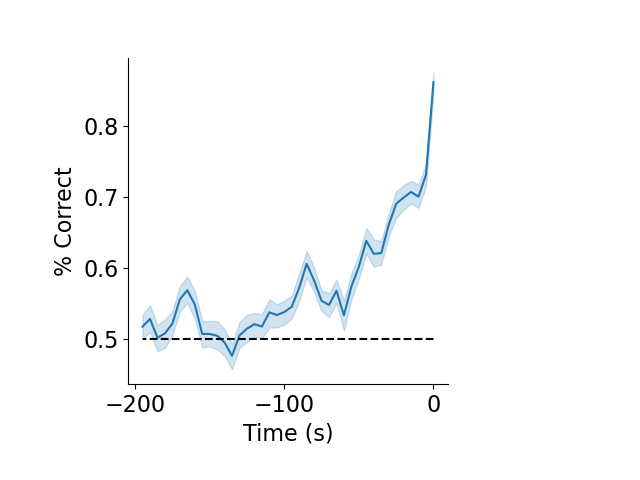

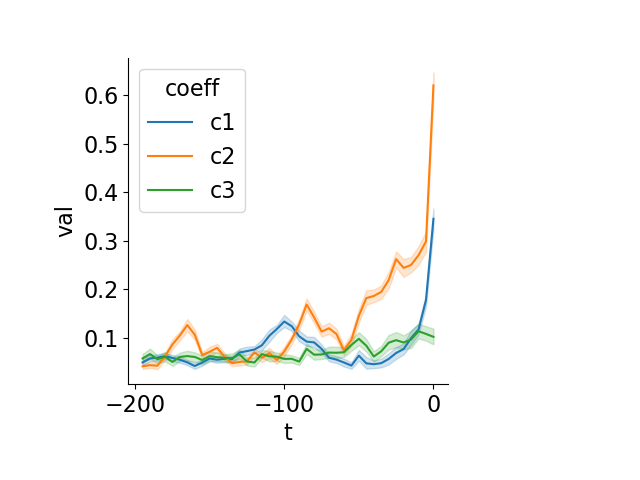

In [5]:
data = []
for k in range(nback):
    data += zip(evaluation[k], [k*-dt*ndown]*nfold)
df = pd.DataFrame(data=data, columns=['val', 't'])

sleepy.set_fontsize(16)
plt.figure()
sns.lineplot(data=df, x='t', y='val')
sns.despine()
x = np.array(df.t)
plt.plot(x, np.ones((len(x),))*0.5, 'k--')
plt.subplots_adjust(bottom=0.2, left=0.2, right=0.7)
plt.ylabel('% Correct')
plt.xlabel('Time (s)')


data = []
for k in range(nback):
    A = np.abs(np.squeeze(slope_dict[k]))
    data += zip(A[:,0], A[:,1], A[:,2], [k*-dt*ndown]*nfold)
df_slope = pd.DataFrame(data=data, columns=['c1', 'c2', 'c3', 't'])

# Melt the DataFrame to convert it to long format
df_slope_long = pd.melt(df_slope, id_vars=['t'], value_vars=['c1', 'c2', 'c3'], var_name='coeff', value_name='val')


plt.figure()
#sns.lineplot(data=df_slope, x='t', y='c1')
#sns.lineplot(data=df_slope, x='t', y='c2')
#sns.lineplot(data=df_slope, x='t', y='c3')
sns.lineplot(data=df_slope_long, x='t', y='val', hue='coeff')
sns.despine()
plt.subplots_adjust(bottom=0.2, left=0.2, right=0.7)



The second figure shows the correlation coefficients for PC1, PC2, and PC3. The prediction clearly relies most on PC2.

# (2) Predict _when_ the next REM episode occurs

(1) We know that the activity of the firing rates and PCs goes up and down with the infraslow slow rhythm (ISR). So just taking all firing rates to predict when the next REM episode will happen is probably very confusing for any algorithm (when just looking at one time point). Therefore I came up with the idea to look at the maximum PC activity during each infraslow cycle and use this to predict when the next episodes comes along. 

For each IS cycle in a NREM block that is not interrupted by a long wake episode, I calculate the time interval till the next REM episode. I build a matrix, where each row contains for each such IS cycle the PC values and a vector holding for each cycle the time till the next REM episode.

here
here
here
here
[1, 1]


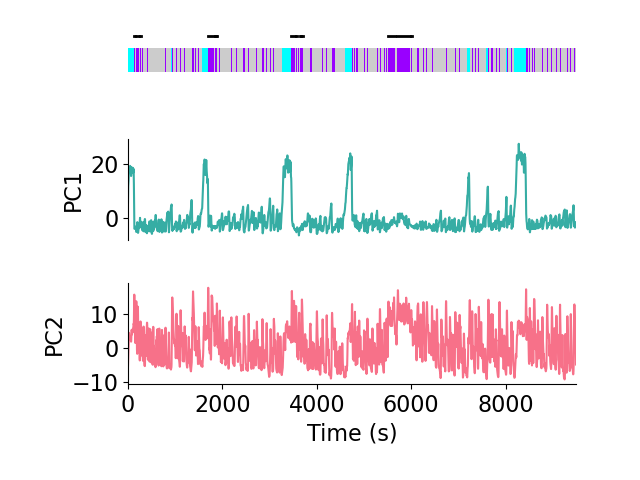

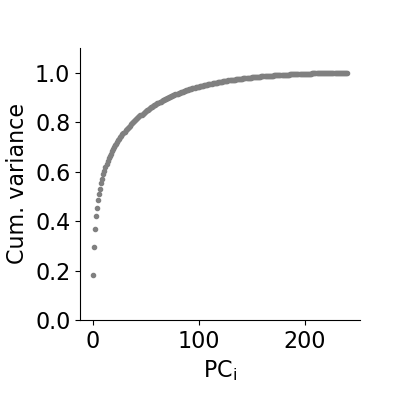

In [25]:
ndim = 2
mouse = 'DL194'
restrict_regions = True


config_file = os.path.join('/Users/tortugar/My Drive/Penn/Programming/Neuropixels', 'mouse_config.txt')
units, cell_info, M, kcut = nx.load_mouse(mouse, config_file)    
nx.exclude_units(units, mouse, config_file)

#br_regions = ['DR', 'PAG', 'CS', 'CLI', 'MB', 'MRN']
#br_regions = ['CS', 'RPO',  'DR', 'PAG', 'P', 'RPO', 'CLI', 'MB']
br_regions = ['P', 'CS', 'RPO', 'MB', 'DR', 'PAG', 'CLI', 'MRN', 'PRNc', 'PRNr']
if restrict_regions:
    ids = cell_info[cell_info.brain_region.isin(br_regions)]['ID']
    ids = [id for id in ids if re.match('.*_good$', id)]
    ids = [id for id in ids if id in list(units.columns)]
    units = units[ids]

# as for wake_dur: both wake_dur=60 and wake_dur=120 seems to work well
PC, V, Vh, sel_idx, df_idx = nx.sigmaramp_pca(units, M, mouse, config_file=config_file, kcuts=kcut, detrend=True, 
                                              nsmooth=1.5, rem_mindur=0, box_filt=[1,4],
                                              wfreq=[1/80,1/50], pc_sign=[-1,1], pzscore=True, wake_dur=120, wake_break=10, ma_thr=20, 
                                              rem_ending=True, ndim=ndim, win=10, pplot=False)

PCorig, V, Vh, idx = nx.sleep_components(units, M, ndim=ndim, nsmooth=nsmooth, wake_dur=60, 
                                     pc_sign=pc_signs[mouse], pzscore=True, 
                                     wake_break=20, kcuts=kcut, detrend=True, ylim=[], pplot=True)


pc_sign_corr = nx.align_pcsign(PC, mouse, kcuts=kcut, rem_pca=0, config_file=config_file)
pprint(pc_sign_corr)
for i,s in enumerate(pc_sign_corr):
   PC[i,:] = PC[i,:] * s

tidx = nx.kcut_idx(M, PC, kcuts=kcut)
M = M[tidx]

array([0.17292304, 0.17292032, 0.17288581, 0.17174526, 0.14141815,
       0.06838052, 0.04093928, 0.00494693])
array([0.18203914, 0.18237115, 0.18529567, 0.20922225, 0.2565213 ,
       0.15176031, 0.09440081, 0.01185507])
'Max performance on test set: 0.256521'
array([-17.245317  ,  11.95991226])


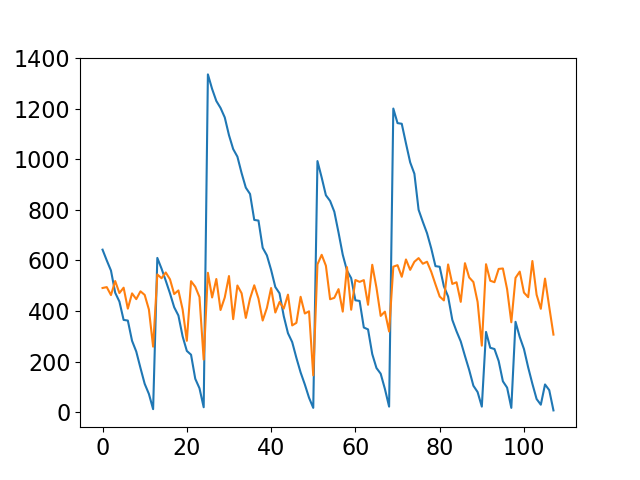

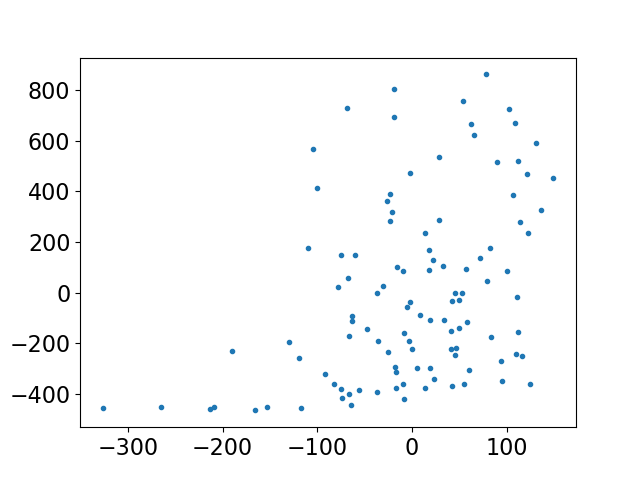

In [26]:
# get all starts of REM sequences
rem_idx = []
seq = sleepy.get_sequences(np.where(M==1)[0])
for s in seq:
    istart = s[0]
    if istart >= iwin:
        rem_idx.append(istart)
rem_idx = np.array(rem_idx)
        

MX, y = [], []
for count,row in df_idx.iterrows():
    i = row['smax']
    tra = row['tra']
    trb = row['trb']
    tmp = np.where(i < rem_idx)[0]
    
    if len(tmp) > 0:
        rems = tmp[0]
        
        d = (rem_idx[rems] - i + 1) * dt        
        #row = PC[:,i]
        row = PCorig[:,tra:trb].max(axis=1)
        
        MX.append(row)
        y.append(d)
        
MX = np.array(MX)
y = np.array(y)
ymean = y.mean()
y = y-ymean

theta = [0, 1, 10, 100, 1000, 5000, 10000, 100000]
Etest, Etrain = pyphi.cross_validation(MX.copy(), y.copy(), theta, nfold=5)
pprint(Etrain)
pprint(Etest)
theta_max = theta[np.argmax(Etest)]
pprint("Max performance on test set: %f" % np.max(Etest))
pprint(k)

A = MX.copy()
for i in range(ndim):
    A[:,i] = A[:,i] - A[:,i].mean()


k = pyphi.ridge_regression(A, y.copy(), theta_max)

plt.figure()
plt.plot(y+ymean)

plt.plot(np.dot(A,k)+ymean)

plt.figure();
plt.plot(np.dot(A,k), y, '.')

# Under development

Include history into prediction

array([0.23987575, 0.23981675, 0.23910549, 0.22620367, 0.15333147,
       0.04009884, 0.00478187, 0.00048756])
array([-0.00560194, -0.00530407, -0.00294225,  0.009209  ,  0.06079195,
        0.03119921,  0.00401247,  0.00041216])
0.060791947195102794


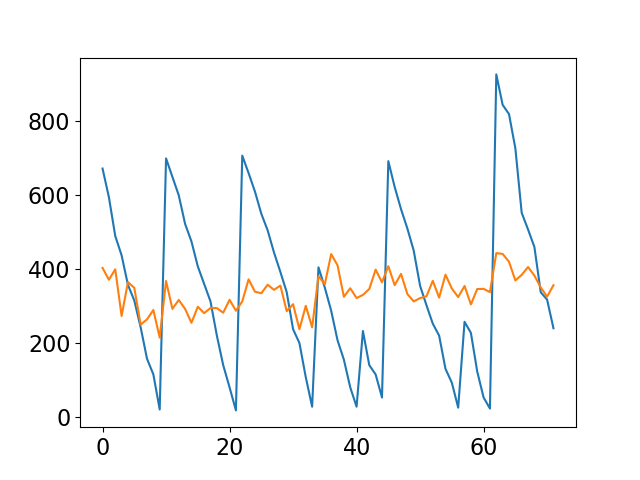

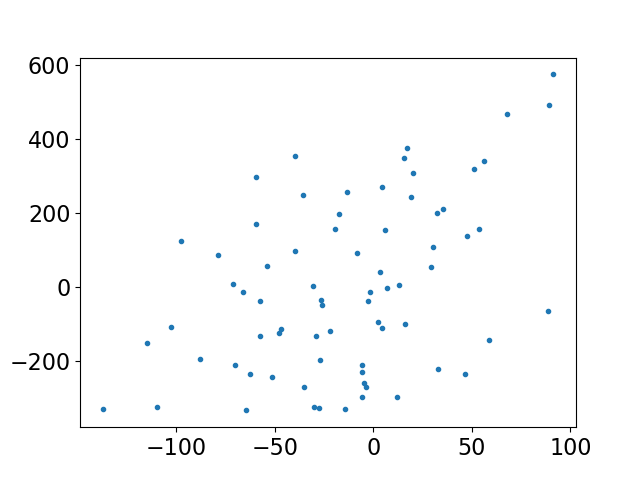

In [7]:
# include history
nback = 4

# get all starts of REM sequences
rem_idx = []
seq = sleepy.get_sequences(np.where(M==1)[0])
for s in seq:
    istart = s[0]
    if istart >= iwin:
        rem_idx.append(istart)
rem_idx = np.array(rem_idx)
        

MX, y = [], []
smax = np.array(df_idx['smax'])
for c in range(nback, len(smax)):
    i = smax[c]
    
    if c <  nback:
        continue
    
    tmp = np.where(i < rem_idx)[0]
    
    if len(tmp) > 0:
        rems = tmp[0]
        
        d = (rem_idx[rems] - i + 1) * dt
        
        
        
        row = PCorig[:,smax[c+1-nback:c+1]]
        
        
        
        row = np.reshape(row.T, (ndim*nback,))
        
        MX.append(row)
        y.append(d)
        
MX = np.array(MX)
y = np.array(y)
ymean = y.mean()
y = y-ymean

theta = [0, 1, 10, 100, 1000, 10000, 100000, 1000000]
Etest, Etrain = pyphi.cross_validation(MX.copy(), y.copy(), theta, nfold=5)
pprint(Etrain)
pprint(Etest)

imax = np.argmax(Etest)
pprint(Etest[imax])

A = MX.copy()
for i in range(ndim):
    A[:,i] = A[:,i] - A[:,i].mean()


k = pyphi.ridge_regression(A, y.copy(), theta[imax])

plt.figure()
plt.plot(y+ymean)

plt.plot(np.dot(A,k)+ymean)

plt.figure();
plt.plot(np.dot(A,k), y, '.')


# Under development
For each mouse calculate for each unit the average, normalized FR during a single IS cycle preceding Wake, MA, NREM, or REM

In [8]:
## (3)
for mouse in mice:
    config_file = os.path.join('/Users/tortugar/My Drive/Penn/Programming/Neuropixels', 'mouse_config.txt')
    units, cell_info, M, kcut = nx.load_mouse(mouse, config_file)    
    nx.exclude_units(units, mouse, config_file)
    
    if restrict_regions:
        ids = cell_info[cell_info.brain_region.isin(br_regions)]['ID']
        ids = [id for id in ids if re.match('.*_good$', id)]
        ids = [id for id in ids if id in list(units.columns)]
        units = units[ids]
        
    #PC, V, Vh, idx = nx.sleep_components(units, M, ndim=ndim, nsmooth=nsmooth, wake_dur=60, 
    #                                     pc_sign=pc_signs[mouse], pzscore=True, 
    #                                     wake_break=20, kcuts=kcut, detrend=True, ylim=[], pplot=True)
    
    if restrict_regions:
        pc_sign_corr = nx.align_pcsign(PC, mouse, kcuts=kcut)
        pprint(pc_sign_corr)
        
        for i,s in enumerate(pc_sign_corr):
            PC[i,:] = PC[i,:] * s
    
    # remaining indices after cutting out KCUT intervals
    tidx = nx.kcut_idx(M, PC, kcuts=kcut)
    M = M[tidx]


    dfis1, df_section1, df_all = nx.is_cycle(mouse, units, [10, 15], ids=ids_sorted[-a:], ma_thr=20, nsmooth=1.5, nstates=nstates, nsections=3, 
                                             min_irem_dur=min_irem_dur, wake_perc=wake_perc, kcuts=kcut, pzscore=True)


    
    # PC, V, Vh, sel_idx, df_idx = nx.sigmaramp_pca(units, M, mouse, config_file=config_file, kcuts=kcut, detrend=True, 
    #                                           nsmooth=3, rem_mindur=0,
    #                                           wfreq=[1/55,1/50], pc_sign=[-1,1], pzscore=True, wake_dur=np.inf, wake_break=00, ma_thr=10, 
    #                                           rem_ending=True, ndim=ndim, win=10)

    


FileNotFoundError: [Errno 2] No such file or directory: 'mouse_config.txt'

# Illustrative example for LDA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Generate synthetic 2D data
np.random.seed(42)
n_samples = 100
mean_class1 = [0, 0]
mean_class2 = [3, 3]
covariance = [[1, 0.5], [0.5, 1]]
X_class1 = np.random.multivariate_normal(mean_class1, covariance, n_samples)
X_class2 = np.random.multivariate_normal(mean_class2, covariance, n_samples)
X = np.vstack((X_class1, X_class2))
y = np.hstack((np.zeros(n_samples), np.ones(n_samples)))

# Fit LDA on the data
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

# Plot the data points and decision boundary
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
coefficients = lda.coef_
intercept = lda.intercept_
line = -coefficients[0, 0] / coefficients[0, 1]
x_vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
y_vals = line * x_vals - intercept / coefficients[0, 1]
plt.plot(x_vals, y_vals, color='red')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('LDA Decision Boundary')
plt.show()
